## **Introduction**

**Available model**
1. rf_more_6class : `(std + mean), ck+`
2. knn_more : `(std + mean), ck+`
3. rf_fewer : `(std + mean), ck+`
4. knn_fewer : `(std + mean), ck+`
5. resmasknet (Py-feat) : - `Facial expression recognition using residual masking network by (Pham et al., 2020)`
6. fernet (Py-feat) - `Deep convolutional network`
7. svm (Py-feat) - `SVM model trained on Histogram of Oriented Gradients extracted from ExpW, CK+, and JAFFE datasets`
8. clf_lin_svm : `Pos landmark, Dis from center, Angle rel to center`
9. clf_poly_svm : `Pos landmark, Dis from center, Angle rel to center`
10. vgg16 : 
`- vgg16 bottleneck features`
11. xception : - `xception bottleneck features`
12. aug_vgg : `augmentation image`
13. proposed model: 
* `( std + mean + landmark + Dist + Angle )` 
* `train from ck, kaggle`
14. ANN model

---
**Available data**
1. ck, ck+ : `https://drive.google.com/drive/folders/1pmmZfIwnuSajCafojd_WsaJ70LMutHmM?usp=sharing`
2. kaggle (FER2013) `https://drive.google.com/drive/folders/1pQAE95FB5oUWA6QqBne8j9THzl0n3A4p?usp=sharing`
3. JAFFE (เป็น dataset ของคนญี่ปุ่น) `https://drive.google.com/drive/folders/1isqq_HY9LxLo829E7UgLfv1AExT9nKuG?usp=sharing`
4. AffectNet : `(อาจารย์กลกรณ์กำลังขอให้)`
5. Aff-Wild2 `(https://drive.google.com/drive/folders/1x0SpKg-4335DbPw2qus6G7E9sFqwiS69?usp=sharing)` : emotion + au
6. AFEW-VA : `https://ibug.doc.ic.ac.uk/resources/afew-va-database/` 
ระดับความรุ่นแรงของอารมณ์
7. FERG-DB : `https://drive.google.com/drive/folders/1M6z2nA0MULuP2Wl89EES9EVtK4Nx_L3z?usp=sharing`
8. RAVDESS : `https://drive.google.com/drive/folders/1bxtpkLiozXwKIr6QzdBPHwOrhKO5_Jw3?usp=sharing`
    * `https://www.youtube.com/watch?v=cxMK2J0P7J0`
    * `https://zenodo.org/record/3255102#.YLYlv6gzaUk`

9. `https://en.wikipedia.org/wiki/Facial_expression_databases#cite_note-11`

---
**Function**
1. convert_class
2. convert_pred
3. load_dataset
4. prepare_kaggle
5. load_model
6. cal_mean_std
7. plot_confus
8. resmasknet_pred
9. evaluate_model
---


1.   label_ck+  = `(1=anger", "3=disgust", "4=fear", "5=happy", "6=sadness", "7=surprise")`
rf_more_6class
2. label_kaggle  = ` (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).`
3. JAFFE = `[5=happy, 6=sadness, 7=surprise, 1=anger, 3=disgust, 4=fear]`
4. label_me      = [ "0",      "1",      "2",    "3",      "4",        "5"   ] 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import dlib
import joblib
import numpy as np
from tqdm.notebook import tqdm
import cv2
import time
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from drive.MyDrive.AIHealthcare.AIcare_Phrase1.resmarknet_test import *
from drive.MyDrive.AIHealthcare.AIcare_Phrase1.fernet_model import *
from drive.MyDrive.AIHealthcare.AIcare_Phrase1.fernet_test import *
from drive.MyDrive.AIHealthcare.AIcare_Phrase1.helper import *

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg_preprocess
from keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint

from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input as xception_preprocess
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder
from keras.layers.normalization import BatchNormalization

In [ ]:
# df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/kaggle/fer2013/fer2013.csv')

# Functions

## convert_class

In [ ]:
def convert_class(df, data_name):
  ##################### midframe 
  if data_name == 'kaggle':
    df.drop(df[df.lable == 6].index, inplace=True)
    df = df.reset_index(drop=True)
  elif data_name == 'ck+':
    df["lable"].replace({1:0, 3:1, 4:2, 5:3, 6:4, 7:5}, inplace=True)
  elif data_name == 'jaffe':
    df["lable"].replace({1:0, 3:1, 4:2, 5:3, 6:4, 7:5}, inplace=True)
  print('convert_class', pd.unique(df['lable']))
  return df

## convert_pred

In [ ]:
def convert_pred(df, model_name):
  if model_name in ['resmasknet', 'clf_lin_svm', 'clf_poly_svm']:
    pass
    # df["lable"].replace({1:0, 3:1, 4:2, 5:3, 6:4, 7:5}, inplace=True)
  elif model_name in ['rf_more_6class', 'knn_more_6class', 'rf_fewer_6class',
                      'knn_fewer_6class', 'rf_feature_6class', 'rf_ck_kaggle',
                      'rf_ck_kaggle_jaffe']:
    df["lable"].replace({1:0, 3:1, 4:2, 5:3, 6:4, 7:5}, inplace=True)
  print('convert_pred', df['lable'].unique())
  return df

## load_dataset

In [ ]:
ls 'drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/'

df_prepro_jaffe.csv  jaffedbase/     JAFFE_df.csv     jaffe_int.csv
jaffe.csv            jaffedbase.zip  jaffe_final.csv  README_FIRST.txt


In [ ]:
def load_dataset(data_name):
  if data_name == 'ck+':
    midframe = np.load("drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/mid_feame_6c.npy", allow_pickle=True)
    df = pd.DataFrame(midframe)
    df.columns = ['image', 'lable']
    df = convert_class(df, data_name)

  elif data_name == 'kaggle':
    df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/kaggle/fer2013/fer2013.csv')
    X, Y = prepare_kaggle(df[df['Usage'] =='PrivateTest'])
    df = pd.DataFrame({'image': X.tolist(),'lable': Y.tolist()})
    df['image'] = df['image'].apply(lambda x: np.array(x,np.float32))
    df = convert_class(df, data_name)
  
  elif data_name == 'jaffe':
    df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/jaffe_final.csv')
    # df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/df_prepro_jaffe.csv')
    df = df[['path','lable']]
    df.columns = ['image', 'lable']
    df['image'] = df['image'].apply(lambda x: cv2.imread(x))
    df["lable"].replace({0:5, 1:6, 2:7, 3:1, 4:3, 5:4}, inplace=True)
    df = convert_class(df, data_name)
  return df

## prepare_kaggle

In [ ]:
def prepare_kaggle(data):
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
    return image_array, image_label

## Prepare dataset

In [ ]:
# %cd drive/MyDrive/AIHealthcare/Emotion_Categ_from_Vdo_frame_img_SeqVoting/
# emotions = ["neutral", "anger", "contempt", "disgust", "fear", "happy", "sadness", "surprise"]
# # emotions = [    "0",     "1",       "2",        "3",      "4",    "5",      "6",        "7"   ]
# observations = glob.glob("source_emotion/*")

### --- CK+

In [ ]:
# neutral_file_dict={}
# img_mean_list = []
# img_std_list = []
# lable_list = []
# emo_list = []
# landmarkls = []

# for obs in tqdm(observations):  
#     obs_id = str(obs[-4:]) # S028

#     emotions_folders = "{0}/*".format(str(obs)) # source_emotion/S028/*
#     emotions_sessions =  glob.glob(emotions_folders) # ['source_emotion/S028/001']
    
#     for each_emotion_session in emotions_sessions:
#         emotion_sequence_folder = "{0}/*".format(each_emotion_session) #source_emotion/S028/001/*
#         emotion_sequence_files = glob.glob(emotion_sequence_folder) #['source_emotion/S028/001/S028_001_00000024_emotion.txt']

#         for emotion_output in emotion_sequence_files: #source_emotion/S028/001/S028_001_00000024_emotion.txt
#             emotion_seq_no = emotion_output[20:23] #001
#             file = open(emotion_output, 'r')
#             emotion= int(float(file.readline())) #1
#             peak_num_list = sorted(glob.glob("source_images/{0}/{1}/*".format(obs_id,emotion_seq_no)))
#             peak_num = len(peak_num_list)
#             mid_num =  math.floor(peak_num/2.0)

#             peak_frame = sorted(glob.glob("source_images/{0}/{1}/*".format(obs_id,emotion_seq_no)))[-1] #source_images/S028/001/S028_001_00000024.png
#             mid_frame = sorted(glob.glob("source_images/{0}/{1}/*".format(obs_id,emotion_seq_no)))[mid_num] #source_images/S028/001/S028_001_00000024.png
#             first_frame = sorted(glob.glob("source_images/{0}/{1}/*".format(obs_id,emotion_seq_no)))[0] #source_images/S028/001/S028_001_00000001.png

#             for i in range(mid_num-1, peak_num):
#               moreframe = sorted(glob.glob("source_images/{0}/{1}/*".format(obs_id,emotion_seq_no)))[i]
#               image = cv2.imread(moreframe)
#               face_image = detect_faces(image)
#               image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)/255.0
#               val = np.reshape(image[:,:,0], -1)
#               img_mean = np.mean(val) # mean feature
#               img_std = np.std(val) # std feature
#               try :
#                 data = np.array(get_landmarks(face_image)['landmarks_vectorised'])      
#               except:
#                 print('i', i) 
#               img_mean_list.append(img_mean)
#               img_std_list.append(img_std)
#               lable_list.append(emotion)
#               landmarkls.append(data)

# dict_more = {'meanf': img_mean_list, 'stdf': img_std_list, 'label': lable_list} 
# df_more_frame = pd.DataFrame(dict_more)

# indexNames = df_more_frame[df_more_frame['label'] == 2].index
# df_more_frame.drop(indexNames , inplace=True)
# print('df_more_frame', df_more_frame.shape)
# landmark_df = pd.DataFrame(np.array(landmarkls))
# %cd ../../../../
# df = pd.concat([df_more_frame, landmark_df], axis=1, join="inner")
# from google.colab import files
# df.to_csv('df6c.csv') 
# files.download('df6c.csv')

# df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/feature/df6c.csv')
# df.head(2)

### ---Kaggle

In [ ]:
# dfkaggle = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/kaggle/fer2013/fer2013.csv')
# # dfkaggle.head(2)

# df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/kaggle/fer2013/fer2013.csv')
# X, Y = prepare_kaggle(df)
# df = pd.DataFrame({'image': X.tolist(),'lable': Y.tolist()})
# df['image'] = df['image'].apply(lambda x: np.array(x,np.float32))
# # df.drop(df[df.lable == 6].index, inplace=True)
# df = df.reset_index(drop=True)
# df["lable"].replace({0:1, 1:3, 2:4, 3:5, 4:6, 5:7}, inplace=True)

# img_mean_list = []
# img_std_list = []
# lable_list = []
# landmarkls = []

# for i in tqdm(range(df.shape[0])):
  
#   gray = df['image'][i].astype('uint8')
#   val = np.reshape(gray, -1)
#   img_mean = np.mean(val) # mean feature
#   img_std = np.std(val) # std feature
#   # print('gray',gray.shape)
#   try:
#     data = np.array(get_landmarks(gray)['landmarks_vectorised'])
#   except:
#     # print('i = ',i)  
#     img_mean = 0
#     img_std = 0
#   img_mean_list.append(img_mean)
#   img_std_list.append(img_std)
#   lable_list.append(df['lable'][i])
#   landmarkls.append(data) 
#   np.append([[0, 1, 2], [3, 4, 5]],[[6, 7, 8]], axis=0)

# print(len(img_mean_list))
# print(len(img_std_list))
# print(len(lable_list))
# print(len(landmarkls))
# df_kaggle = pd.DataFrame({'meanf': img_mean_list,'stdf': img_std_list, 'label':lable_list})
# landmark_df = pd.DataFrame(np.array(landmarkls))
# df_kaggle = pd.concat([df_kaggle, landmark_df], axis=1, join="inner")
# df_kaggle.drop(df_kaggle[df_kaggle.meanf == 0].index, inplace=True)

# from google.colab import files
# df_kaggle.to_csv('df_kaggle.csv') 
# files.download('df_kaggle.csv')

### ---JAFFE

In [ ]:
# df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/jaffe_final.csv')
# df = df[['path','lable']]
# df.columns = ['image', 'lable']
# df['image'] = df['image'].apply(lambda x: cv2.imread(x))
# df["lable"].replace({0:5, 1:6, 2:7, 3:1, 4:3, 5:4}, inplace=True)

# img_mean_list = []
# img_std_list = []
# lable_list = []
# landmarkls = []

# for i in tqdm(range(df.shape[0])):
#   gray = df['image'][i]
#   val = np.reshape(gray, -1)
#   img_mean = np.mean(val) # mean feature
#   img_std = np.std(val) # std feature
#   try:
#     data = np.array(get_landmarks(gray)['landmarks_vectorised'])
#   except:
#     print('i = ',i)  
#     img_mean = 0
#     img_std = 0
#   img_mean_list.append(img_mean)
#   img_std_list.append(img_std)
#   lable_list.append(df['lable'][i])
#   landmarkls.append(data) 

# print(len(img_mean_list))
# print(len(img_std_list))
# print(len(lable_list))
# print(len(landmarkls))
# df_jaffe = pd.DataFrame({'meanf': img_mean_list,'stdf': img_std_list, 'label':lable_list})
# landmark_df = pd.DataFrame(np.array(landmarkls))
# df_jaffe = pd.concat([df_jaffe, landmark_df], axis=1, join="inner")
# df_jaffe.drop(df_jaffe[df_jaffe.meanf == 0].index, inplace=True)

# from google.colab import files
# df_jaffe.to_csv('df_jaffe.csv') 
# files.download('df_jaffe.csv')

### **Train model**

In [ ]:
dfck = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/feature/ckplus.csv')
dfkaggle = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/feature/df_kaggle.csv')
df_jaffe = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/feature/df_jaffe.csv')
dfkaggle['meanf'] = dfkaggle['meanf']/255.0
dfkaggle['stdf'] = dfkaggle['stdf']/255.0
df_jaffe['meanf'] = df_jaffe['meanf']/255.0
df_jaffe['stdf'] = df_jaffe['stdf']/255.0

# result = dfck.append(dfkaggle, sort=False)
# print(result.shape)

df = pd.concat([dfck, dfkaggle, df_jaffe], ignore_index = True)
df.reset_index()
print(df.shape)

(23715, 271)


In [ ]:
# sns.countplot(x = 'label',
#               data = df,
#               order = df.label.value_counts().index);

In [ ]:
X = df.drop('label', axis=1)
y = df['label'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
from numpy import where

sm = SMOTE(sampling_strategy='auto')
X_sm, y_sm = sm.fit_resample(df.drop('label', axis=1), df['label'])

# smote = SMOTE(ratio='minority')
# X_sm, y_sm = smote.fit_sample(result.drop('label', axis=1), result['label'])

# # summarize the new class distribution
# counter = Counter(y)
# print(counter)
# # scatter plot of examples by class label
# for label, _ in counter.items():
# 	row_ix = where(y == label)[0]
# 	pyplot.scatter(X_sm[row_ix, 0], X_sm[row_ix, 1], label=str(label))
# pyplot.legend()
# pyplot.show()

# newdata = pd.DataFrame(y_sm)
# sns.countplot(x = 0,
#               data = newdata,
#               order = newdata[0].value_counts().index);

### -- RandomForest

In [ ]:
# X = df.drop('label', axis=1)
# y = df['label'] 

# # rf = RandomForestClassifier(n_estimators=1000, random_state=0).fit(X, y)
# rf = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight='balanced').fit(X, y)
# joblib.dump(rf, "rf_ck_kaggle_jaffe_balanced.joblib")
# !cp rf_ck_kaggle_jaffe_balanced.joblib drive/MyDrive/AIHealthcare/Emotion_Categ_from_Vdo_frame_img_SeqVoting/model/

### -- ANN

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, shuffle = False)

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(np.array(y).reshape(-1,1))
y_train = enc.transform(np.array(y_train).reshape(-1,1))
y_test = enc.transform(np.array(y_test).reshape(-1,1))

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_dim = 270))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
# model.add(Dense(output_dim = 6, activation='softmax'))
model.add(Dense(6, activation='softmax')) 
# model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)
# model.predict(X.values[100].reshape(1,-1))

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

In [ ]:
  plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)

### ---Vgg16

In [ ]:
# X_train = df.drop('label', axis=1).values
# y_train = df['label'].values

# clf_poly_svm = SVC(kernel="poly", random_state=11, probability=True, tol=1e-3)
# clf_poly_svm.fit(X_train, y_train)
# joblib.dump(clf_poly_svm, "model/clf_poly_svm.joblib")

# clf_lin_svm = SVC(kernel='linear', random_state=7, probability=True, tol=1e-3)
# clf_lin_svm.fit(X_train, y_train)
# joblib.dump(clf_lin_svm, "model/clf_lin_svm.joblib")

In [ ]:
# scaler = MinMaxScaler()
# sdss = scaler.fit_transform(df.drop('label', axis=1))

# X_train, X_test, y_train, y_test = train_test_split(sdss, df['label'], test_size=0.2)

# xgb = XGBClassifier(n_estimators=100)
# xgb = xgb.fit(X_train, y_train)
# preds = xgb.predict(X_test)
# acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
# print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
# joblib.dump(xgb, "xgb_more.joblib")

# xgboost = XGBClassifier(max_depth=5, learning_rate=0.01,
#                         n_estimators=100, gamma=0, 
#                         min_child_weight=1, subsample=0.8,
#                         colsample_bytree=0.8, reg_alpha=0.005)
# xgboost = xgboost.fit(X_train, y_train)
# preds = xgboost.predict(X_test)
# accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

# print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))
# joblib.dump(xgboost, "xgb_opt_more.joblib")

## load_model

In [ ]:
def load_model(model_name, model_type, model_path):
  
  if model_name == 'rf_more_6class':
    model = joblib.load(str(model_path)+model_name+'.joblib')
  elif model_name == 'knn_more_6class':
    model = joblib.load(str(model_path)+model_name+'.joblib')
  elif model_name == 'rf_fewer_6class':
    model = joblib.load(str(model_path)+model_name+'.joblib')     
  elif model_name == 'knn_fewer_6class':
    model = joblib.load(str(model_path)+model_name+'.joblib')     
  elif model_name == 'clf_lin_svm':
    model = joblib.load(str(model_path)+model_name+'.joblib')  
  elif model_name == 'clf_poly_svm':
    model = joblib.load(str(model_path)+model_name+'.joblib') 
  elif model_name in ['rf_feature_6class','rf_ck_kaggle', 'rf_ck_kaggle_jaffe']:
    model = joblib.load(str(model_path)+model_name+'.joblib')       
  elif model_name == 'xgb_opt_more_6class':
    model = joblib.load(str(model_path)+model_name+'.joblib')       
  elif model_name == 'resmasknet':
    model = ResMaskNet()
  elif model_name == 'fernet':
    model = ferNetModule()

  elif model_name == 'svm':
    pca_model = joblib.load("drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/emo_hog_pca.joblib")
    classifier = joblib.load("drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/emoSVM38.joblib")
    scaler = joblib.load("drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/emo_hog_scalar.joblib")
    model = [pca_model, classifier, scaler]

  elif model_name == 'vgg16':
    model_VGG = VGG16(weights='imagenet', include_top=False)
    VGG16_model = Sequential()
    VGG16_model.add(GlobalAveragePooling2D(input_shape=(10, 10, 512)))
    VGG16_model.add(Dense(6, activation='softmax'))
    VGG16_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    VGG16_model.load_weights('drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/weights_best_VGG16_6c.hdf5')
    model = [model_VGG, VGG16_model]
    return model

  elif model_name == 'xception':
    model_Xception = Xception(weights='imagenet', include_top=False)
    Xception_model = Sequential()
    Xception_model.add(GlobalAveragePooling2D(input_shape=(11, 11, 2048)))
    Xception_model.add(Dense(6, activation='softmax'))
    Xception_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    Xception_model.load_weights('drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/weights_best._Xception6c.hdf5')
    model = [model_Xception, Xception_model]
    return model

  elif model_name == 'aug_vgg':
    vgg_aug = VGG16(include_top=False, weights='imagenet',input_shape=(350,350,3))
    vgg_aug_output = vgg_aug.layers[-1].output
    vgg_aug_model = Model(vgg_aug.input, vgg_aug_output)
    model_vgg_aug = Sequential()
    model_vgg_aug.add(vgg_aug_model)
    model_vgg_aug.add(GlobalAveragePooling2D(input_shape=(10, 10, 512)))
    model_vgg_aug.add(Dense(6, activation='sigmoid'))
    model_vgg_aug.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model_vgg_aug.load_weights('drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/weights_best_vgg_aug_6c.hdf5')
    model = model_vgg_aug
  return model

## cal_mean_std

In [ ]:
def cal_mean_std(image):
  val = np.reshape(image[:,:,0], -1)
  img_mean = np.mean(val)
  img_std = np.std(val)
  X = np.array([img_mean, img_std]).reshape(1, -1)
  return X

## plot_confus

In [ ]:
def plot_confus(pred_lable, truelable):
  print(metrics.classification_report(pred_lable, truelable.to_list()))
  print('Accuracy: ',metrics.accuracy_score(truelable.to_list(), pred_lable))
  mat = confusion_matrix(truelable.to_list(), pred_lable)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
  plt.xlabel('true label')
  plt.ylabel('predicted label'); 

from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(9, 8)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim()
  b += 0.5 
  t -= 0.5
  plt.ylim(b, t) 
  plt.show() 

## pyfeat_model

In [ ]:
def pyfeat_model(model, img, data_name, model_name):

  if data_name in ['ck+','jaffe']:
    detectordlib = dlib.get_frontal_face_detector()
    predictorlib = dlib.shape_predictor("drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/shape_predictor_68_face_landmarks.dat")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detectordlib(gray)
    landmark_listxy = []

    for face in faces:
      x1 = face.left()
      y1 = face.top()
      x2 = face.right()
      y2 = face.bottom()
      detected_faces1 = [[x1, y1, x2, y2, 1]]

      if model_name in ['fernet','svm']:
        landmarks = predictorlib(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            temp = [x, y]
            landmark_listxy.append(temp)
        landmark_listxy = [np.array(landmark_listxy)] 
        if model_name == 'fernet':
          landmarks = np.transpose(landmark_listxy)
          if landmarks.shape[-1] == 68:
              landmarks = convert68to49(landmarks)
              landmarks = landmarks.T    

        elif model_name == 'svm':
          convex_hull, new_lands = extract_face(frame=img,detected_faces=detected_faces1,landmarks=landmark_listxy,size_output=112)
          hogs = extract_hog(frame=convex_hull, visualize=False)
          if len(hogs.shape) < 2:
              hogs = hogs.reshape(1,-1)
          if len(new_lands.shape) > 1:
              new_lands = new_lands.flatten().reshape(1,-1)     
          pca_transformed_frame = model[0].transform(model[2].fit_transform(hogs))
          feature_cbd = np.concatenate((pca_transformed_frame, new_lands), 1)     
          predict = []   
          for keys in model[1]:
              au_pred_con = model[1][keys].decision_function(feature_cbd)
              au_pred_con = au_pred_con[0] 
              predict.append(au_pred_con)
          predict = np.array(predict).reshape(1, -1)[0]                 

  elif data_name == 'kaggle':
    detectordlib = dlib.get_frontal_face_detector()
    predictorlib = dlib.shape_predictor("drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/shape_predictor_68_face_landmarks.dat")
    gray = img.astype('uint8')
    img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    detected_faces1 = [[0, 0, 48, 48, 1]]
    landmark_listxy = []
    faces = detectordlib(gray, 1)
    facedlib = 'found'

    if model_name == ('fernet' or 'svm'):
      try:
        landmarks = predictorlib(gray, faces[0])
      except:
        facedlib = 'not_found'
        
      if facedlib != 'not_found':
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            temp = [x, y]
            landmark_listxy.append(temp)
        landmark_listxy = [np.array(landmark_listxy)] 
        landmarks = np.transpose(landmark_listxy)
        if landmarks.shape[-1] == 68:
            landmarks = convert68to49(landmarks)
            landmarks = landmarks.T   

      if model_name == 'svm':
        convex_hull, new_lands = extract_face(frame=img,detected_faces=detected_faces1,landmarks=landmark_listxy,size_output=112)
        hogs = extract_hog(frame=convex_hull, visualize=False)
        if len(hogs.shape) < 2:
            hogs = hogs.reshape(1,-1)
        if len(new_lands.shape) > 1:
            new_lands = new_lands.flatten().reshape(1,-1)     
        pca_transformed_frame = model[0].transform(model[2].fit_transform(hogs))
        feature_cbd = np.concatenate((pca_transformed_frame, new_lands), 1)     
        predict = []   
        for keys in model[1]:
            au_pred_con = model[1][keys].decision_function(feature_cbd)
            au_pred_con = au_pred_con[0] 
            predict.append(au_pred_con)
        predict = np.array(predict).reshape(1, -1)[0]                 

  if model_name == 'resmasknet':
    predict = model.detect_emo(img,detected_faces1)[0]
  elif model_name == 'fernet':
    try:
      predict = model.detect_emo(img,landmarks)[0]
    except:
      predict = [1, 0, 0, 0 ,0 ,0]
  elif model_name == 'svm':
    pass
    
  swapemo = [predict[0], predict[1], predict[2], predict[3], predict[4], predict[5]]
  emo_arr = np.argmax(np.array(swapemo))
  return emo_arr

## svm_linear_poly

In [ ]:
faceDet = cv2.CascadeClassifier("drive/MyDrive/AIHealthcare/AIcare_Phrase1/haarcascades/haarcascade_frontalface_default.xml")
faceDet_two = cv2.CascadeClassifier("drive/MyDrive/AIHealthcare/AIcare_Phrase1/haarcascades/haarcascade_frontalface_alt2.xml")
detector = dlib.get_frontal_face_detector() 
predictor = dlib.shape_predictor("drive/MyDrive/AIHealthcare/AIcare_Phrase1/model/shape_predictor_68_face_landmarks.dat") 

def get_landmarks(image):
    data={}
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
        # calculate the center of gravity
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        # calculate the distance from center from both axis.
        # this information is used to get the angle relative to center point.
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]
        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            # append x and y values
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            # calculate the euclidiean distance from center
            dist = np.linalg.norm(coornp-meannp)
            # append the distance to the feature vector
            landmarks_vectorised.append(dist)
            # apend the angle relative to the center of gravity.
            landmarks_vectorised.append(math.degrees(math.atan2(y,x)))
        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1:
        data['landmarks_vestorised'] = "error"
    return data

def detect_faces(img):
  # print('img', img.shape)
  face = faceDet.detectMultiScale(img, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)
  face_two = faceDet_two.detectMultiScale(img, scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

  if len(face) == 1:
      facefeatures = face
  elif len(face_two) == 1:
      facefeatures = face_two
  else:
      facefeatures = ""

  for (x, y, w, h) in facefeatures: 
      img = img[y:y+h, x:x+w] 
      try:
          out = cv2.resize(img, (350, 350)) 
      except:
          pass 
  return out

## img_model_pred

In [ ]:
def img_model_pred(img, model, model_name):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = detect_faces(gray)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = Image.fromarray(img)
    img = img.resize((350, 350))
    x = np.expand_dims(img, axis=0)
    if model_name == 'vgg16':
      x = model[0].predict(vgg_preprocess(x))
    elif model_name == 'xception':
      x = model[0].predict(xception_preprocess(x))
    elif model_name == 'aug_vgg':
      result = np.argmax(model.predict(x))
    if model_name in ['vgg16', 'xception']:
      result = np.argmax(model[1].predict(x))  
    return result

## evaluate_model

In [ ]:
def evaluate_model(df, model, data_name, model_name): #df 1.image 2.label  
  pred_lable = []
  timefps = []
  prev_frame_time = 0
  new_frame_time = 0
  
  for i in tqdm(range(df.shape[0])):

    if model_name in ['rf_more_6class', 'knn_more_6class', 'rf_fewer_6class','knn_fewer_6class']:
      img = df['image'][i].astype('float32')
      image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.0
      X = cal_mean_std(image)
      ypred = model.predict(X)
      pred_lable.append(ypred[0])

    if model_name in ['xgb_more_6class', 'xgb_opt_more_6class', 'rf_feature_6class', 'rf_ck_kaggle', 'rf_ck_kaggle_jaffe']:
      if data_name != 'kaggle':
        face_image = detect_faces(df['image'][i])
      else:
        face_image = df['image'][i].astype('uint8')
        
      image = cv2.cvtColor(df['image'][i], cv2.COLOR_BGR2RGB)/255.0
      X = cal_mean_std(image).tolist()[0]

      try:
        data = np.array(get_landmarks(face_image)['landmarks_vectorised']).tolist()
      except:
        pass

      x_test = np.array(X+data).reshape(1,-1)
      ypred = model.predict(x_test)
      pred_lable.append(ypred[0])

    elif model_name == 'resmasknet':
      ypred = pyfeat_model(model, df['image'][i],data_name, model_name)
      pred_lable.append(ypred)

    elif model_name == 'fernet':
      ypred = pyfeat_model(model, df['image'][i],data_name, model_name)
      pred_lable.append(ypred)

    elif model_name == 'svm':
      ypred = pyfeat_model(model, df['image'][i],data_name, model_name)
      pred_lable.append(ypred)

    elif model_name in ['clf_lin_svm' , 'clf_poly_svm']:
      img = df['image'][i].astype('uint8')
      if data_name != 'kaggle':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      image = detect_faces(img)
      data = np.array(get_landmarks(image)['landmarks_vectorised'])
      emo_arr = model.predict_proba(data.reshape(1, -1))[0]
      emo_arr = np.argmax(np.array(emo_arr))
      pred_lable.append(emo_arr)
    
    elif model_name in 'vgg16':
      ypred = img_model_pred(df['image'][i], model, model_name)
      pred_lable.append(ypred)

    elif model_name in 'xception':
      ypred = img_model_pred(df['image'][i], model, model_name)
      pred_lable.append(ypred)

    elif model_name in 'aug_vgg':
      ypred = img_model_pred(df['image'][i], model, model_name)
      pred_lable.append(ypred)

    new_frame_time = time.time()
    fps = 1/(new_frame_time-prev_frame_time)
    prev_frame_time = new_frame_time
    timefps.append(fps)
    
  print('FPSav', (sum(timefps) / len(timefps)))  
  pred_df = pd.DataFrame({'lable': pred_lable})
  pred_df = convert_pred(pred_df, model_name)
  plot_confus(pred_df, df['lable'])

# API Application

convert_class [3 4 5 0 1 2]



FPSav 0.8164511115234566
convert_pred [5 3 4 2 1 0]
              precision    recall  f1-score   support

           0       0.10      0.75      0.18         4
           1       0.17      0.78      0.28         9
           2       0.25      0.11      0.15        19
           3       0.42      0.85      0.56        26
           4       0.77      0.33      0.46        92
           5       0.61      0.40      0.49        62

    accuracy                           0.42       212
   macro avg       0.39      0.53      0.35       212
weighted avg       0.59      0.42      0.44       212

Accuracy:  0.419811320754717


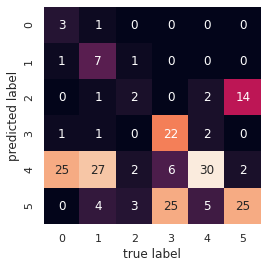

In [ ]:
# dataset -> ['ck+', 'kaggle', 'jaffe']
df = load_dataset("jaffe")

# model -> [rf_more_6class, knn_more_6class,
#           rf_fewer_6class, knn_fewer_6class,
#           clf_lin_svm, clf_poly_svm,
#           resmasknet, fernet, svm,
#           vgg16, xception, aug_vgg,
#           rf_feature_6class, rf_ck_kaggle,
#           rf_ck_kaggle_jaffe.joblib]

model = load_model('resmasknet','joblib', 'drive/MyDrive/AIHealthcare/Emotion_Categ_from_Vdo_frame_img_SeqVoting/model/') #(model, model_type)

# Evaluate
evaluate_model(df, model, 'jaffe', 'resmasknet') # (df, model, dataset_name, model_name)

1. https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio
2. https://github.com/yfliao/Emotion-Classification-Ravdess
3. https://towardsdatascience.com/speech-emotion-recognition-using-ravdess-audio-dataset-ce19d162690

In [ ]:
# df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/jaffe_final.csv')
# df.head(5)
# jaffe = ['HAP','SAD','SUR','ANG','DIS','FEA'] 
# jaffe = [ 0,    1,     2,    3,    4,    5  ]
# jaffe = [ 5,    6,     7,    1,    3,    4  ]
# ck+  = [anger", "disgust", "fear", "happy", "sadness", "surprise"]
# ck+  = [ "1",      "3",      "4",    "5",      "6",        "7"   ] 

# df = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/jaffe.csv')
# df.columns = ['happy','sadness','surprise','anger','disgust','fear']

# array_jaffe = df[['HAP','SAD','SUR','ANG','DIS','FEA']].values
# lable_list = []
# for i in range(array_jaffe.shape[0]):
#   lable = np.argmax(array_jaffe[i])
#   lable_list.append(lable)

# lable = pd.DataFrame(np.array(lable_list),columns=['lable'])
# df_final = pd.concat([df, lable], axis=1, join="inner")
# from google.colab import files
# df_final.to_csv('jaffe_final.csv') 
# files.download('jaffe_final.csv')

# pathlist = []
# import glob
# for filepath in glob.iglob(r'drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/jaffedbase/*.tiff'):
#   pathlist.append(filepath)
#   # pathlist.append(filepath[64:70])

# jaffe = pd.read_csv('drive/MyDrive/AIHealthcare/AIcare_Phrase1/data/JAFFE/JAFFE_df.csv')
# jaffe['PIC'] = jaffe['PIC'].str.replace('-','.')
# jaffe['path'] = 0

# for i in range(jaffe.shape[0]):
#   for j in range(len(pathlist)):
#     if jaffe['PIC'][i] == pathlist[j][64:70]:
#       jaffe['path'][i] = pathlist[j]
#       # print('ok')
# # jaffe

# df = pd.concat([df_more_frame, landmark_df], axis=1, join="inner")
# from google.colab import files
# jaffe.to_csv('jaffe.csv') 
# files.download('jaffe.csv')